In [1]:
import warnings # ignore boring warnings
warnings.filterwarnings("ignore")

import numpy as np
import os
import tensorflow as tf
from skimage import transform
import matplotlib.pyplot as plt
%matplotlib inline
os.environ['CUDA_VISIBLE_DEVICES'] = "0" #use GPU:0
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu,enable=True)
    

In [2]:

# load model
model = tf.keras.models.load_model('../01-PretrainedCNNModel/2DCNNDemoModel.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 159, 159, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [3]:
# get last conv layer 
last_conv_layer_name = "max_pooling2d_2"
classifier_layer_names = [
    "flatten",
    "dropout",
    "dense",
    "dense_1"]


last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(model.input, last_conv_layer.output)


classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

In [4]:
classifier_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 18, 64)]      0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0         
_________________________________________________________________
dropout (Dropout)            (None, 20736)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1327168   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,327,363
Trainable params: 1,327,363
Non-trainable params: 0
_________________________________________________________________


## make data

In [5]:
# load_data
data_2duv = np.load('/data1/qzhang/small_dataset_pnas/original/original_dataset.npz')['twoduv']
labels = np.load('/data1/qzhang/small_dataset_pnas/original/original_dataset.npz')['labels']

# oever view
print('Original 2duv shape:',data_2duv.shape)
print('labels:',np.unique(labels))

# preprocess labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels_cat = encoder.fit_transform(labels)
print(encoder.classes_)
print(np.unique(labels_cat))


# preprocess 2duv data

# split dataset
from sklearn.model_selection import train_test_split
train_data,test_data,train_label,test_label = train_test_split(data_2duv.reshape(-1,161,161,1),labels_cat,
                                                               stratify = labels_cat,
                                                               test_size=0.2,
                                                               random_state=42)

train_x,val_x,train_y,val_y = train_test_split(train_data,train_label,stratify=train_label,
                                               test_size = 0.125,random_state=42)


print('Train data:',train_x.shape)
print('Validation data:',val_x.shape)
print('Test data:',test_data.shape)

# prprocess 2duv data

mean = train_x.mean()
std = train_x.std()

train_x -= mean
train_x /= std

print('Mean value:',mean)
print('Std value:',std)

print('Train datset after nomolization,Mean:%f,Std:%f'%(train_x.mean(),train_x.std()))

train_x = train_x.clip(-2,2)
print('Max:%d, Min:%d'%(train_x.max(),train_x.min()))


# preprocess val_data and test_data
val_x -= mean
val_x /= std

val_x = val_x.clip(-2,2)

test_data -= mean
test_data /= std

test_data = test_data.clip(-2,2)

Original 2duv shape: (2700, 25921)
labels: ['a-helix' 'b-sheet' 'other-SS']
['a-helix' 'b-sheet' 'other-SS']
[0 1 2]
Train data: (1890, 161, 161, 1)
Validation data: (270, 161, 161, 1)
Test data: (540, 161, 161, 1)
Mean value: -1.59583661486646e-24
Std value: 1.1228893279331382e-21
Train datset after nomolization,Mean:0.000000,Std:1.000000
Max:2, Min:-2


# Plot CAM

In [6]:
# we def. some usefull functions first...

def get_heatmap(index):
    experience_sample = train_x[index]

    img_array = experience_sample.reshape(-1,161,161,1)

    #Compute activations of the last conv layer and make the tape watch it.
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Retrieve the activation channel corresponding to the top predicted class.
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    #This is the gradient of the top predicted class with regard to the output feature map of the last convolutional layer.
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    
    # post_preprocessing
    heatmap = np.maximum(heatmap, 0) 
    heatmap /= np.max(heatmap)
    heatmap = np.flip(heatmap,axis=0) 
    
    pic = transform.resize(heatmap,(161, 161),order=2)
    
    return pic


label: helix
Raw data of 2DUV
Class Activation Map


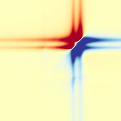

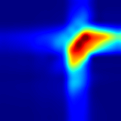

In [7]:
label_dict = {0:'helix',1:'sheet',2:'other-SS'}

num = 70
# label:
print('label:',label_dict[train_label[num]])

# raw 2duv data

plt.figure(figsize=(161,161),dpi=1)
print('Raw data of 2DUV')
# plt.title('Raw data of 2DUV')
plt.axis('off')
plt.imshow(train_x[num].reshape(161,161),origin='lower',cmap = 'RdYlBu_r',vmin=-2,vmax=2)
plt.savefig('./raw_2duv_example.png')

# CAM pic
plt.figure(figsize=(161,161),dpi=1)
print('Class Activation Map')
# plt.title('Class Activation Map')
plt.axis('off')
plt.imshow(get_heatmap(index=num),cmap = 'jet')
plt.savefig('./cam_2duv_example.png')

# plot superimposed pic

In [8]:
img_path = './raw_2duv_example.png'
img = tf.keras.preprocessing.image.load_img(img_path,target_size=(161,161))
img = tf.keras.preprocessing.image.img_to_array(img)


hemp_path = './cam_2duv_example.png'
heatmap = tf.keras.preprocessing.image.load_img(hemp_path)
heatmap = tf.keras.preprocessing.image.img_to_array(heatmap)

superimposed_img = heatmap * 0.4 + img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
superimposed_img.save('./superimposed_img.png')

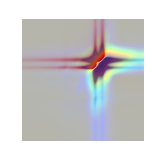

In [9]:
superimposed_img